<a href="https://colab.research.google.com/github/NataliaOsiecka/SkinCancer/blob/main/NoweDaneSkinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Loading data and libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.8/394.8 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.0/462.0 KB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 77.7 MB/s eta 0:00:00
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4849 sha256=87c234ef3804a2d1cf8c5af910367ce16e1701c173e86d461fbaf041369cb828
  Stored in directory: /root/.cache/pip/wheels/a0/16/9c/5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-cp38-cp38-linux_x86_64.whl

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import glob
import math
import os
import random
import shutil
import tensorflow as tf
#from sklearn.utils import class_weight 
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from google.colab.patches import cv2_imshow

In [4]:
filePath = '/content/drive/MyDrive/rożne/hmnist_28_28_RGB.csv'
dataSet = pd.read_csv(filePath)
dataSet.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


2. Get familiar with the data

In [5]:
Label = dataSet["label"]
Data = dataSet.drop(columns=["label"]) 
Data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,192,153,193,195,155,192,197,154,185,202,...,134,173,124,138,183,147,166,185,154,177
1,25,14,30,68,48,75,123,93,126,158,...,82,60,39,55,25,14,28,25,14,27
2,192,138,153,200,145,163,201,142,160,206,...,149,167,129,143,159,124,142,136,104,117
3,38,19,30,95,59,72,143,103,119,171,...,73,44,26,36,25,12,17,25,12,15
4,158,113,139,194,144,174,215,162,191,225,...,201,209,166,185,172,135,149,109,78,92


In [6]:
Data.shape

(10015, 2352)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


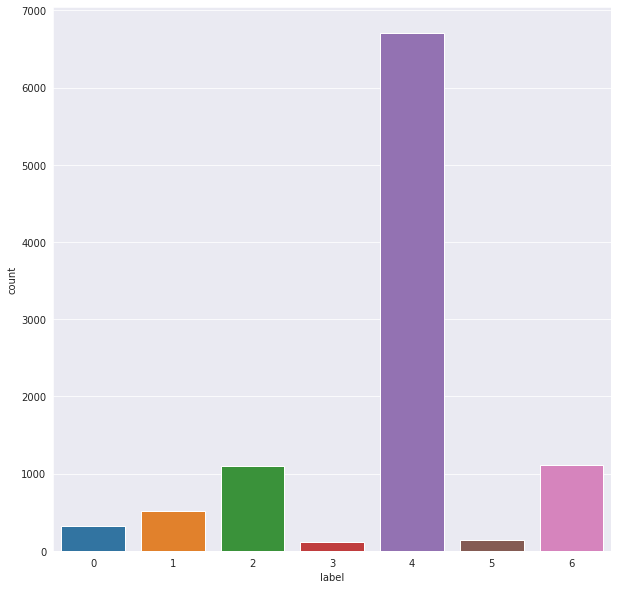

In [7]:
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(Label)

deal with imbalanced data by balancing classes

In [8]:
oversample = RandomOverSampler()
Data,Label  = oversample.fit_resample(Data,Label)
Data = np.array(Data).reshape(-1,28,28,3)
print('Shape of Data :',Data.shape)

Shape of Data : (46935, 28, 28, 3)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


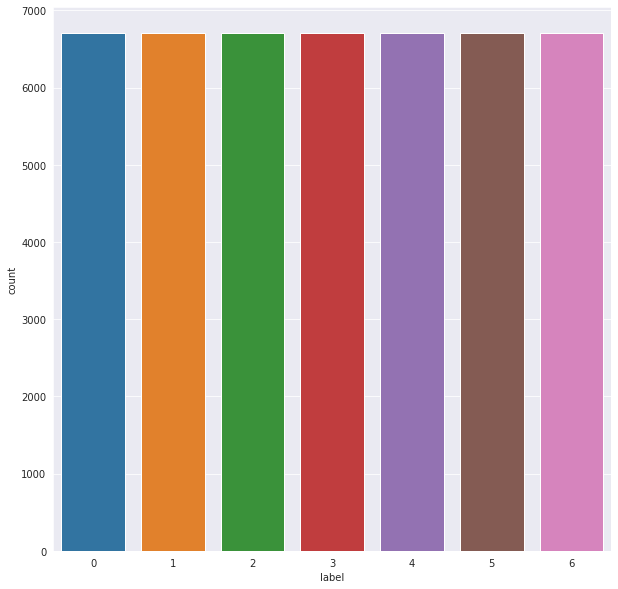

In [9]:
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(Label)

In [10]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

In [11]:
classes = {4: 'nv',
           6: 'mel',
           2: 'bkl', 
           1: 'bcc',
           5: 'vasc',
           0: 'akiec',
           3: 'df'}
'''classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}'''

"classes = {4: ('nv', ' melanocytic nevi'),\n           6: ('mel', 'melanoma'),\n           2 :('bkl', 'benign keratosis-like lesions'), \n           1:('bcc' , ' basal cell carcinoma'),\n           5: ('vasc', ' pyogenic granulomas and hemorrhage'),\n           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),\n           3: ('df', 'dermatofibroma')}"

Split data into test and dataset

In [12]:
X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [13]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 49)

In [14]:
print(X_train.shape)
print(X_test.shape)
#print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
#print(y_val.shape)

(35201, 28, 28, 3)
(5867, 28, 28, 3)
(35201,)
(5867,)


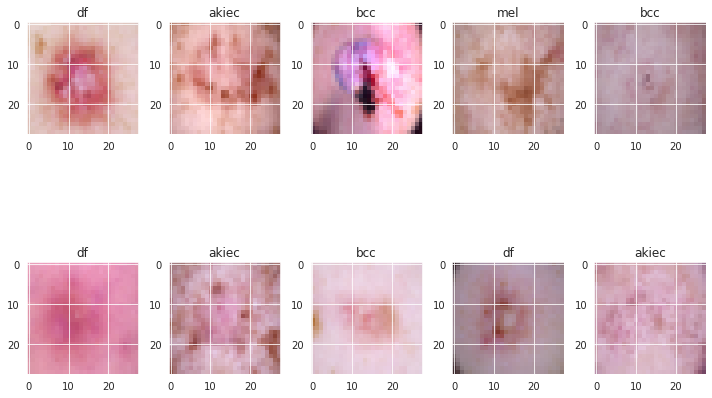

In [15]:
#plotting images
f , ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0 
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_train[k].reshape(28,28,3))
        ax[i,j].set_title(classes[y_train[k]])
        k = k + 1
    plt.tight_layout()

In [16]:
#one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
#y_val = to_categorical(y_val)

In [17]:
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


3. build train, test and validation generators

In [18]:
X_train = X_train.astype('float32')

In [19]:
X_test = X_test.astype('float32')

In [20]:
X_train /= 255
X_test /= 255

In [18]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range = 10,
                                        zoom_range = 0.1,
                                        shear_range = 0.2,
                                        width_shift_range = 0.1,
                                        height_shift_range = 0.2,
                                        horizontal_flip=True, 
                                        vertical_flip=True)


4. Build and train model

In [21]:
initializer1 = tf.keras.initializers.HeNormal()

initializer2 = tf.keras.initializers.GlorotUniform()

In [52]:
network = Sequential()
network.add(Conv2D(filters=32, kernel_size=(3,3), activation = 'relu', input_shape = (28,28,3), kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', padding='same', kernel_initializer=initializer1))
network.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', padding='same', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu', padding='same', kernel_initializer=initializer1))
network.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu', padding='same', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Conv2D(filters=256, kernel_size=(1,1), activation = 'relu', padding='same', kernel_initializer=initializer1))
network.add(Conv2D(filters=256, kernel_size=(1,1), activation = 'relu', padding='same', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(MaxPool2D(pool_size=(2,2)))

network.add(Flatten())

#network.add(Dropout(0.2))
network.add(Dense(units = 256, activation = 'relu', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(Dense(units = 128, activation = 'relu', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(Dense(units = 64, activation = 'relu', kernel_initializer=initializer1))
network.add(BatchNormalization())
network.add(Dense(units = 32, activation = 'relu', kernel_initializer=initializer1, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0001, l2= 0.01)))
network.add(BatchNormalization())
network.add(Dense(units = 7, activation = 'softmax', kernel_initializer=initializer2))
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)         

In [53]:
network.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

In [55]:
es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.001, patience = 3, verbose =1)
model_cp = ModelCheckpoint(filepath = 'best_model1.h5', monitor = 'val_accuracy', save_best_only = True, verbose = 1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.5, min_lr=0.00001)

In [56]:
history = network.fit(X_train, 
                      y_train,
                      batch_size = 128,
                      epochs = 20,
                      validation_data = (X_test, y_test),
                      callbacks=[es, model_cp, learning_rate_reduction])

Epoch 1/20
276/276 [==============================] - 137s 489ms/step - loss: 1.8670 - accuracy: 0.5488 - val_loss: 2.3325 - val_accuracy: 0.2754

Epoch 00001: val_accuracy improved from -inf to 0.27544, saving model to best_model1.h5
Epoch 2/20
276/276 [==============================] - 129s 467ms/step - loss: 0.6851 - accuracy: 0.8369 - val_loss: 0.8871 - val_accuracy: 0.7096

Epoch 00002: val_accuracy improved from 0.27544 to 0.70956, saving model to best_model1.h5
Epoch 3/20
276/276 [==============================] - 135s 489ms/step - loss: 0.3974 - accuracy: 0.8923 - val_loss: 0.6559 - val_accuracy: 0.7777

Epoch 00003: val_accuracy improved from 0.70956 to 0.77774, saving model to best_model1.h5
Epoch 4/20
276/276 [==============================] - 128s 466ms/step - loss: 0.2796 - accuracy: 0.9159 - val_loss: 0.5434 - val_accuracy: 0.8050

Epoch 00004: val_accuracy improved from 0.77774 to 0.80501, saving model to best_model1.h5
Epoch 5/20
276/276 [==============================]

5. testing the model

In [57]:
network.evaluate(X_test , y_test)
#predictions=network.predict(X_test)
#predictions = np.argmax(predictions, axis=1)

184/184 [==============================] - 7s 36ms/step - loss: 0.0596 - accuracy: 0.9882


[0.0596269853413105, 0.9882392883300781]

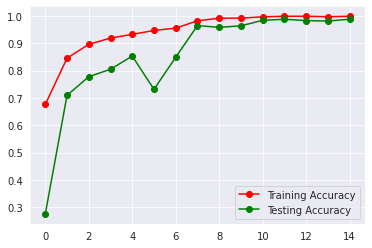

In [58]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

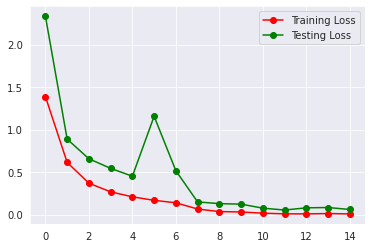

In [59]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [60]:
y_pred  = network.predict(X_test).round()

In [61]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred , target_names =target_names ))

              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00       858
         bcc       0.99      1.00      1.00       836
         bkl       0.98      1.00      0.99       837
          df       1.00      1.00      1.00       812
          nv       1.00      0.92      0.95       809
        vasc       1.00      1.00      1.00       838
         mel       0.96      1.00      0.98       877

   micro avg       0.99      0.99      0.99      5867
   macro avg       0.99      0.99      0.99      5867
weighted avg       0.99      0.99      0.99      5867
 samples avg       0.99      0.99      0.99      5867



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


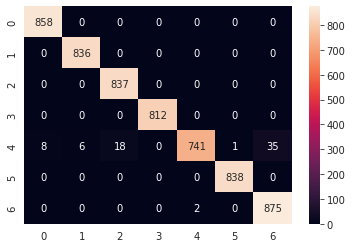

In [62]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g');

In [63]:
from tensorflow.keras.models import load_model
model = load_model('/content/best_model1.h5')

In [64]:
model.evaluate(X_test, y_test)

184/184 [==============================] - 6s 30ms/step - loss: 0.0596 - accuracy: 0.9882


[0.0596269853413105, 0.9882392883300781]

In [66]:
y_pred  = model.predict(X_test).round()

In [67]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred , target_names =target_names ))

              precision    recall  f1-score   support

       akiec       1.00      1.00      1.00       858
         bcc       0.99      1.00      1.00       836
         bkl       0.98      1.00      0.99       837
          df       1.00      1.00      1.00       812
          nv       1.00      0.92      0.95       809
        vasc       1.00      1.00      1.00       838
         mel       0.96      1.00      0.98       877

   micro avg       0.99      0.99      0.99      5867
   macro avg       0.99      0.99      0.99      5867
weighted avg       0.99      0.99      0.99      5867
 samples avg       0.99      0.99      0.99      5867



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


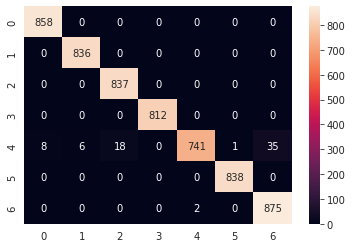

In [68]:
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g');